In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.preprocessing import Normalizer
from sklearn import preprocessing
from sklearn.decomposition import PCA

In [2]:
data = pd.read_csv('./acoustic_extinguisher.csv')
data.dropna(inplace=True)

In [3]:
data.head()

,SIZE,FUEL,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY,STATUS
0,1,gasoline,10,96,0.0,75,0
1,1,gasoline,10,96,0.0,72,1
2,1,gasoline,10,96,2.6,70,1
3,1,gasoline,10,96,3.2,68,1
4,1,gasoline,10,109,4.5,67,1


In [4]:
print(data.dtypes)
print(len(data))

SIZE           int64
FUEL          object
DISTANCE       int64
DESIBEL        int64
AIRFLOW      float64
FREQUENCY      int64
STATUS         int64
dtype: object
17442


In [5]:
label_encoder = preprocessing.LabelEncoder()
data['FUEL'] = label_encoder.fit_transform(data['FUEL'])

In [6]:
print(data.dtypes)

SIZE           int64
FUEL           int32
DISTANCE       int64
DESIBEL        int64
AIRFLOW      float64
FREQUENCY      int64
STATUS         int64
dtype: object


In [7]:
data.isnull().sum()*100/len(data)

SIZE         0.0
FUEL         0.0
DISTANCE     0.0
DESIBEL      0.0
AIRFLOW      0.0
FREQUENCY    0.0
STATUS       0.0
dtype: float64

<Axes: >

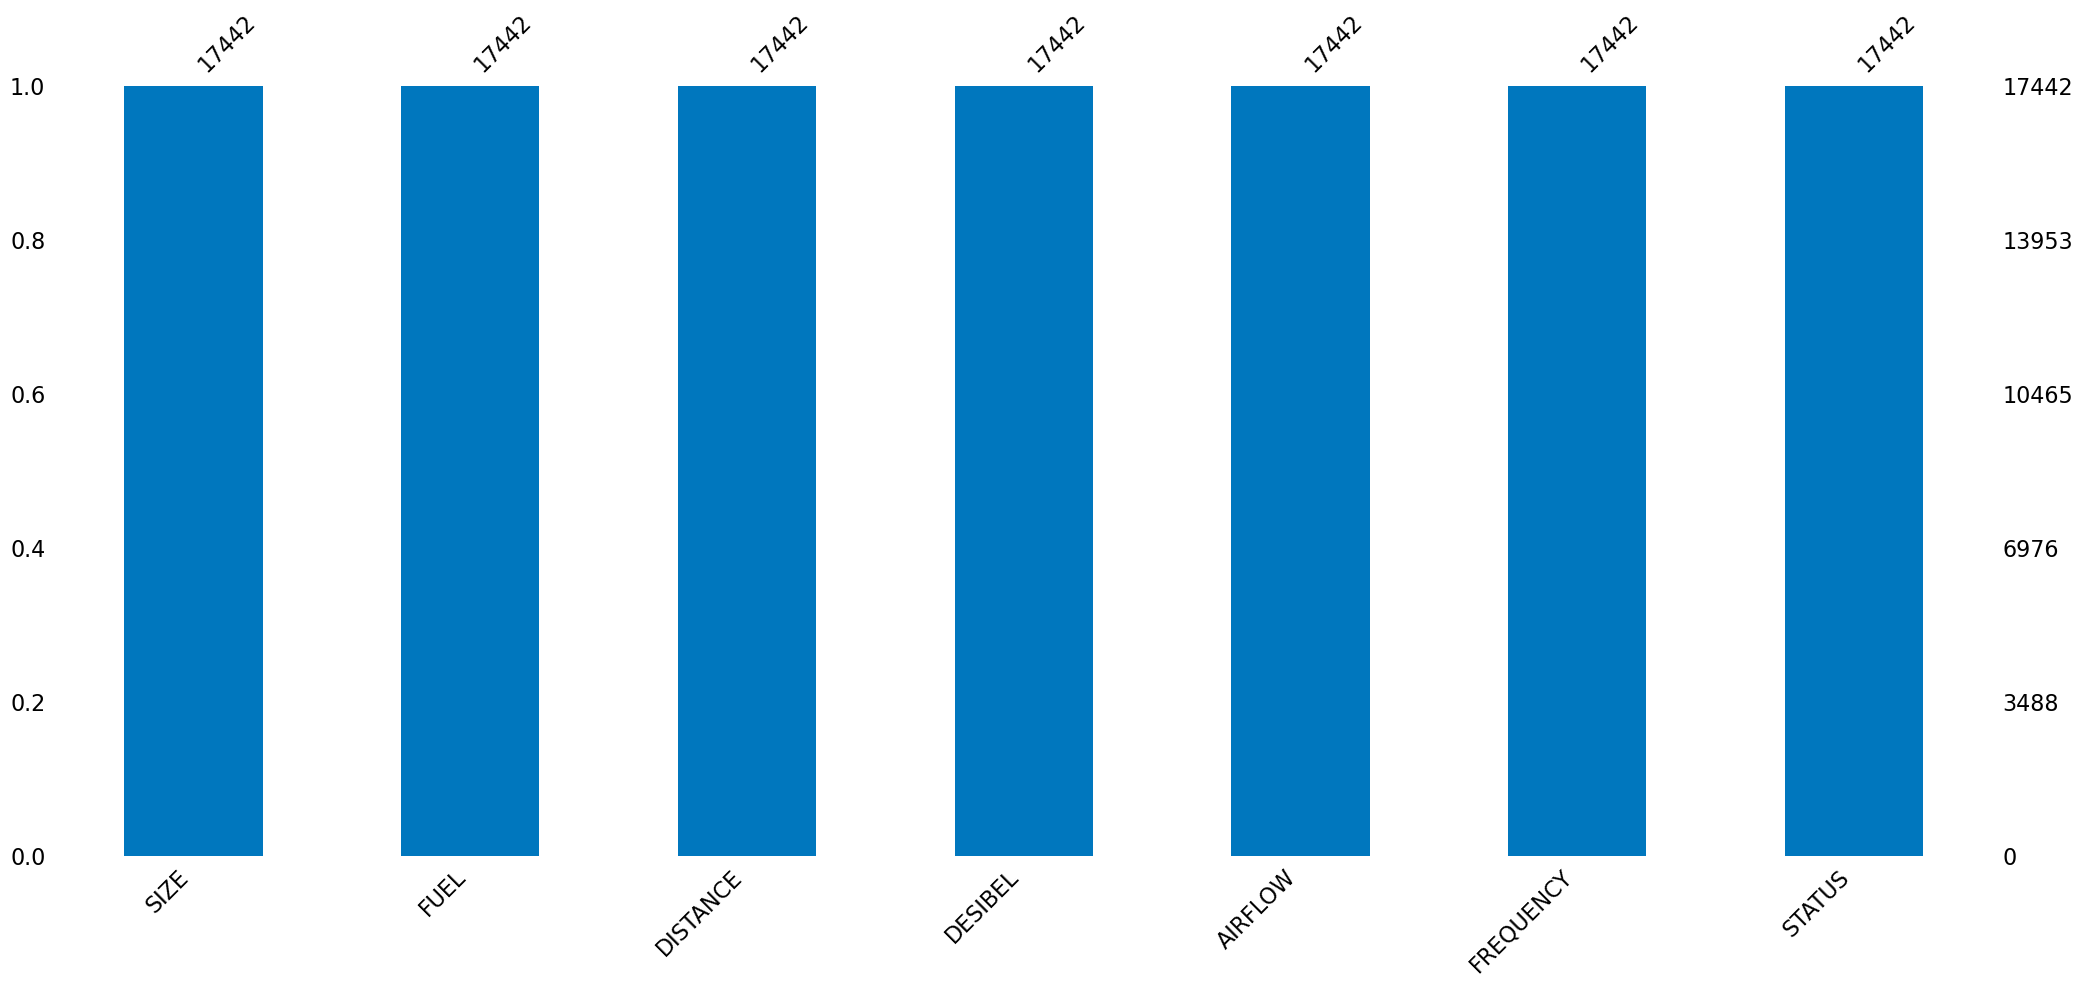

In [8]:
msno.bar(data, color="#0077be")

In [9]:
X_raw = data[['SIZE','FUEL','DISTANCE','DESIBEL','AIRFLOW','FREQUENCY']]
Y_raw = data['STATUS']

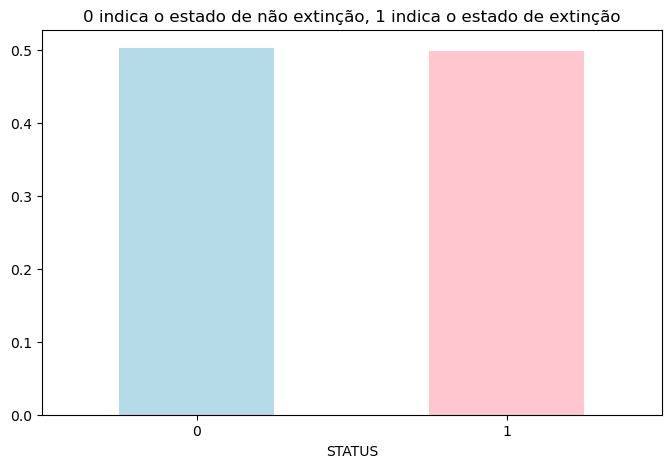

In [10]:
fig = plt.figure(figsize = (8,5))
data.STATUS.value_counts(normalize = True).plot(kind='bar', color= ['lightblue','pink'], alpha = 0.9, rot=0)
plt.title('0 indica o estado de não extinção, 1 indica o estado de extinção')
plt.show()

In [11]:
pca = PCA(n_components=0.95)
pca.fit(X_raw)

PCA(n_components=0.95)

In [12]:
Z = pca.transform(X_raw)
Z

array([[-89.36616167,  41.75340715],
       [-89.36359154,  38.83833634],
       [-89.52135786,  36.78686677],
       ...,
       [ 90.72760631, -30.77220896],
       [ 90.94162187, -32.62806336],
       [ 91.11270058, -34.51301865]])

In [13]:
Z.mean(axis=0)

array([ 6.82107990e-15, -1.09583761e-16])

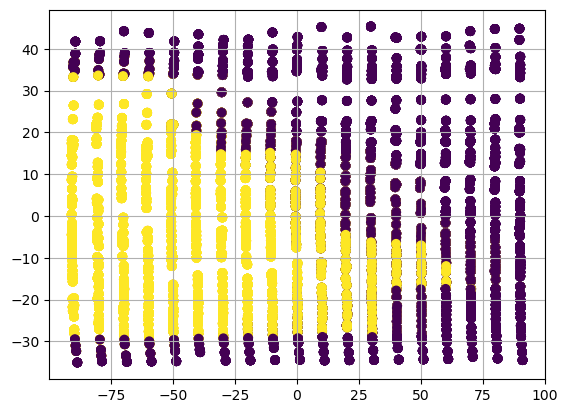

In [14]:
plt.scatter(Z[:,0],Z[:,1],c=Y_raw)
plt.grid()

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X_raw, Y_raw, test_size =0.2, stratify = Y_raw, random_state = 42)

In [16]:
X_train.dtypes

SIZE           int64
FUEL           int32
DISTANCE       int64
DESIBEL        int64
AIRFLOW      float64
FREQUENCY      int64
dtype: object

In [17]:
Y_train.dtypes

dtype('int64')

In [18]:
print(len(X_train))
print(len(X_test))
print(len(X_train)/len(X_raw))

13953
3489
0.7999656002751978


In [19]:
print(Y_test)

13166    0
13324    0
7076     0
14251    0
11853    1
        ..
10403    1
16481    1
11864    1
115      1
11264    0
Name: STATUS, Length: 3489, dtype: int64


In [20]:
Z_train, Z_test, yz_train, yz_test = train_test_split(Z, Y_raw, test_size=0.2, stratify = Y_raw, random_state=42)

In [21]:
model_1 = Pipeline((("scaler", StandardScaler()), ("log_reg", LogisticRegression()))).fit(X_train, Y_train)
y_pred_1 = model_1.predict(X_test)
y_pred_1t = model_1.predict(X_train)

model_2 = Pipeline((("scaler", StandardScaler()), ("linear_svc", LinearSVC(C=1, max_iter=1000000, dual=True)))).fit(X_train, Y_train)
y_pred_2 = model_2.predict(X_test)
y_pred_2t = model_2.predict(X_train)

model_3 = Pipeline((("scaler", StandardScaler()), ("poly_features", PolynomialFeatures(degree=3, include_bias=False)), ("log_reg", LogisticRegression(max_iter=50000)))).fit(X_train, Y_train)
y_pred_3 = model_3.predict(X_test)
y_pred_3t = model_3.predict(X_train)

model_4 = Pipeline((("scaler", StandardScaler()), ("poly_features", PolynomialFeatures(degree=3, include_bias=False)), ("poli_SVM", (LinearSVC(C=1, max_iter=50000))))).fit(X_train, Y_train)
y_pred_4 = model_4.predict(X_test)
y_pred_4t = model_4.predict(X_train)

model_5 = Pipeline((("scaler", StandardScaler()), ("poly_features", PolynomialFeatures(degree=3, include_bias=False)), ("log_reg", LogisticRegression(penalty=None, max_iter=1000)))).fit(Z_train, yz_train)
y_pred_5 = model_5.predict(Z_test)
y_pred_5t = model_5.predict(Z_train)

c:\Users\Claudia\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Claudia\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


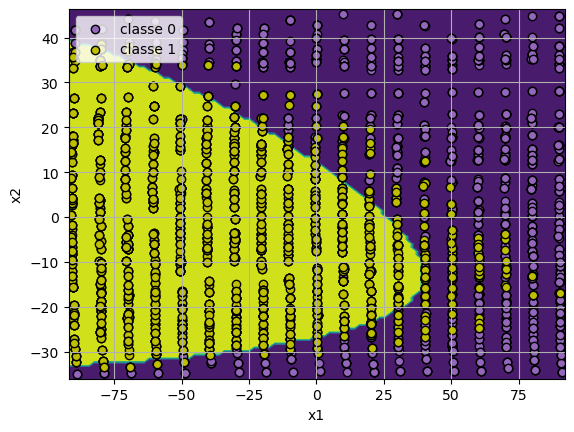

In [22]:
disp_1 = DecisionBoundaryDisplay.from_estimator(model_5,Z_test,response_method="predict",alpha=1)
disp_1.ax_.scatter(Z_test[yz_test==0,0],Z_test[yz_test==0,1],c='tab:purple',label="classe 0",edgecolor="k")
disp_1.ax_.scatter(Z_test[yz_test==1,0],Z_test[yz_test==1,1],c='y',label="classe 1",edgecolor="k")
disp_1.ax_.legend()
plt.xlabel("x1")
plt.ylabel("x2")
disp_1.ax_.grid()

Matriz de Confusão:
[[1553  199]
 [ 265 1472]]
Accuracy: 86.70%


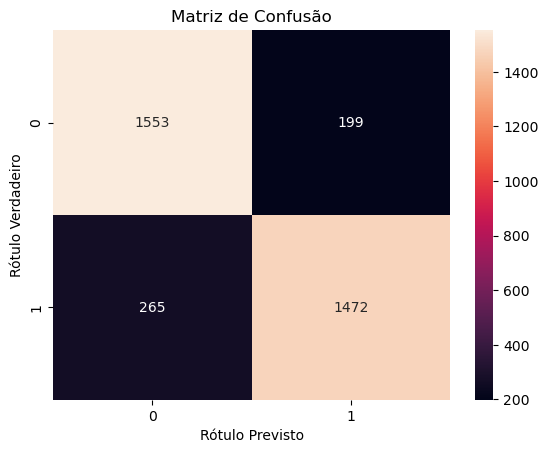

In [23]:
cm = confusion_matrix(Y_test, y_pred_1)
acc_reg_test = accuracy_score(Y_test, y_pred_1)
print("Matriz de Confusão:")
print(cm)
print("Accuracy: {:.2f}%".format(acc_reg_test * 100))


sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Rótulo Previsto')
plt.ylabel('Rótulo Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

Matriz de Confusão:
[[1558  194]
 [ 267 1470]]
Accuracy: 86.79%


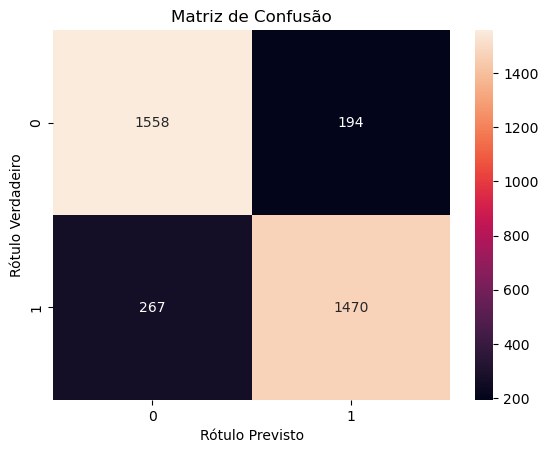

In [32]:
cm = confusion_matrix(Y_test, y_pred_2)
acc_reg_test = accuracy_score(Y_test, y_pred_2)
print("Matriz de Confusão:")
print(cm)
print("Accuracy: {:.2f}%".format(acc_reg_test * 100))


sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Rótulo Previsto')
plt.ylabel('Rótulo Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

Matriz de Confusão:
[[1669   83]
 [ 104 1633]]
Accuracy: 94.64%


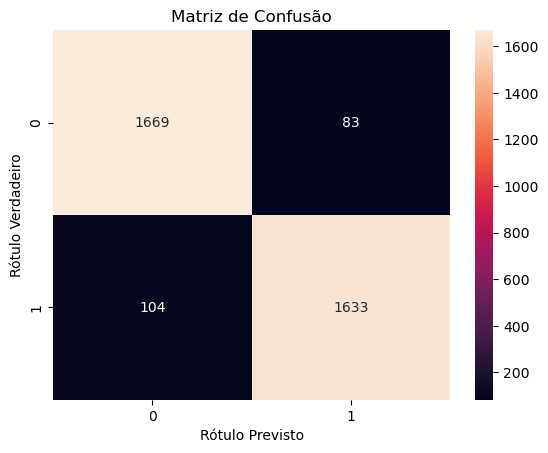

In [33]:
cm = confusion_matrix(Y_test, y_pred_3)
acc_reg_test = accuracy_score(Y_test, y_pred_3)
print("Matriz de Confusão:")
print(cm)
print("Accuracy: {:.2f}%".format(acc_reg_test * 100))


sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Rótulo Previsto')
plt.ylabel('Rótulo Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

Confusion Matrix:
[[1669   83]
 [ 101 1636]]
Accuracy: 94.73%


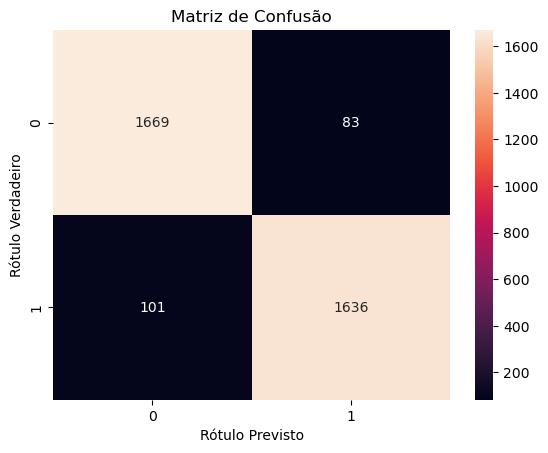

In [26]:
cm = confusion_matrix(Y_test, y_pred_4)
acc_reg_test = accuracy_score(Y_test, y_pred_4)
print("Matriz de Confusão:")
print(cm)
print("Accuracy: {:.2f}%".format(acc_reg_test * 100))


sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Rótulo Previsto')
plt.ylabel('Rótulo Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

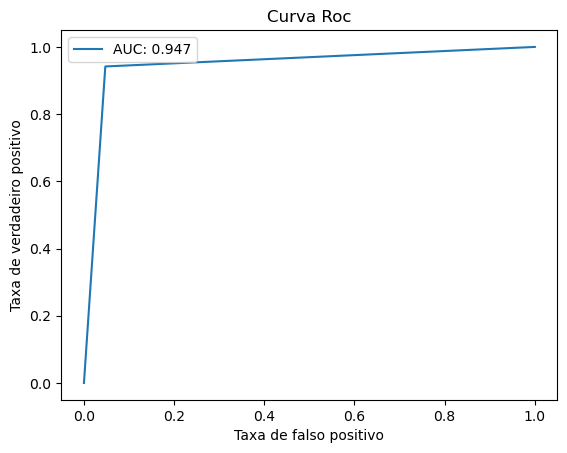

In [27]:
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_4)
auc = roc_auc_score(Y_test, y_pred_4)

plt.plot(fpr, tpr, label='AUC: {:.3f}'.format(auc))
plt.xlabel('Taxa de falso positivo')
plt.ylabel('Taxa de verdadeiro positivo')
plt.title('Curva Roc')
plt.legend()
plt.show()

In [28]:
accuracy = accuracy_score(Y_test, y_pred_1)
accuracy_0 = accuracy_score(Y_train, y_pred_1t)
print(f'Accuracy with Test data: {accuracy}')
print(f'Accuracy with Train data: {accuracy_0}')

report = classification_report(Y_test, y_pred_1)
report_0 = classification_report(Y_train, y_pred_1t)
print(report)
print(report_0)

Accuracy with Test data: 0.8670106047578102
Accuracy with Train data: 0.8783057407009245
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1752
           1       0.88      0.85      0.86      1737

    accuracy                           0.87      3489
   macro avg       0.87      0.87      0.87      3489
weighted avg       0.87      0.87      0.87      3489

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      7007
           1       0.89      0.86      0.88      6946

    accuracy                           0.88     13953
   macro avg       0.88      0.88      0.88     13953
weighted avg       0.88      0.88      0.88     13953



In [29]:
accuracy = accuracy_score(Y_test, y_pred_2)
accuracy_0 = accuracy_score(Y_train, y_pred_2t)
print(f'Accuracy with Test data: {accuracy}')
print(f'Accuracy with Train data: {accuracy_0}')


report = classification_report(Y_test, y_pred_2)
report_0 = classification_report(Y_train, y_pred_2t)
print(report)
print(report_0)

Accuracy with Test data: 0.8678704499856692
Accuracy with Train data: 0.8775890489500466
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1752
           1       0.88      0.85      0.86      1737

    accuracy                           0.87      3489
   macro avg       0.87      0.87      0.87      3489
weighted avg       0.87      0.87      0.87      3489

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      7007
           1       0.89      0.86      0.87      6946

    accuracy                           0.88     13953
   macro avg       0.88      0.88      0.88     13953
weighted avg       0.88      0.88      0.88     13953



In [30]:
accuracy = accuracy_score(Y_test, y_pred_3)
accuracy_0 = accuracy_score(Y_train, y_pred_3t)
print(f'Accuracy with Test data: {accuracy}')
print(f'Accuracy with Train data: {accuracy_0}')


report = classification_report(Y_test, y_pred_3)
report_0 = classification_report(Y_train, y_pred_3t)
print(report)
print(report_0)

Accuracy with Test data: 0.9464029807967899
Accuracy with Train data: 0.9481831864115244
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1752
           1       0.95      0.94      0.95      1737

    accuracy                           0.95      3489
   macro avg       0.95      0.95      0.95      3489
weighted avg       0.95      0.95      0.95      3489

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      7007
           1       0.95      0.94      0.95      6946

    accuracy                           0.95     13953
   macro avg       0.95      0.95      0.95     13953
weighted avg       0.95      0.95      0.95     13953



In [31]:
accuracy = accuracy_score(Y_test, y_pred_4)
accuracy_0 = accuracy_score(Y_train, y_pred_4t)
print(f'Accuracy with Test data: {accuracy}')
print(f'Accuracy with Train data: {accuracy_0}')


report = classification_report(Y_test, y_pred_4)
report_0 = classification_report(Y_train, y_pred_4t)
print(report)
print(report_0)

Accuracy with Test data: 0.947262826024649
Accuracy with Train data: 0.9499749157887193
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1752
           1       0.95      0.94      0.95      1737

    accuracy                           0.95      3489
   macro avg       0.95      0.95      0.95      3489
weighted avg       0.95      0.95      0.95      3489

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      7007
           1       0.95      0.95      0.95      6946

    accuracy                           0.95     13953
   macro avg       0.95      0.95      0.95     13953
weighted avg       0.95      0.95      0.95     13953

